In [2]:
import torchaudio
import IPython.display as ipd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

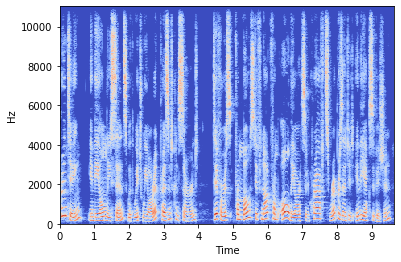

In [5]:
def griffin_lim_reconstruct_demo():
    dataset = torchaudio.datasets.LJSPEECH('./data')
    wave, sr, _, txt = dataset[0]
    wave = wave[0].numpy().reshape(-1)
    
    n_fft = int(0.05*sr)
    n_mels = 80
    f_min = 125
    f_max = 7600
    S_db = librosa.power_to_db(np.abs(librosa.stft(wave))**2)
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='linear')
    S_pow = librosa.db_to_power(S_db)
    wave_recon = librosa.core.griffinlim(np.sqrt(S_pow))
    librosa.output.write_wav('data/orig_sample.wav', wave, sr)
    librosa.output.write_wav('data/recon_sample.wav', wave_recon, sr)
griffin_lim_reconstruct_demo()

In [6]:
ipd.Audio('data/orig_sample.wav')

In [9]:
ipd.Audio('data/recon_sample.wav')